In [158]:
from glob import glob

model_result_paths = glob("./data/judgements/*/*/*.json")

In [159]:
eval_dataset_dict = {
    "elyza__ELYZA-tasks-100": "ELYZA-tasks-100",
    "yuzuai__rakuda-questions": "Rakuda",
    "lightblue__tengu_bench": "Tengu-Bench",
    "lightblue__japanes-mt-bench-oneshot": "MT-Bench",
}

In [160]:
import pandas as pd

all_result_dfs = []

for model_result_path in model_result_paths:
    temp_df = pd.read_json(model_result_path, lines=True)
    temp_df["judge_model"] = model_result_path.split("/")[3]
    temp_df["eval_dataset"] = eval_dataset_dict[model_result_path.split("/")[4]]
    temp_df["model_name"] = model_result_path.split("/")[5].replace(".json", "")
    
    all_result_dfs.append(temp_df)

In [161]:
import pandas as pd

all_result_df = pd.concat(all_result_dfs)

all_result_df["dataset_category"] = all_result_df["eval_dataset"] + " " + all_result_df["Category"]

In [162]:
eval_dataset_names = all_result_df.eval_dataset.unique()
model_names = all_result_df.model_name.unique()

In [163]:
eval_corr_results = {}
for eval_dataset_name in eval_dataset_names:
    eval_corr_results[eval_dataset_name] = {}
    for model_name in model_names:
        eval_corr_results[eval_dataset_name][model_name] = all_result_df[(all_result_df.eval_dataset == eval_dataset_name) & (all_result_df.model_name == model_name)].score.mean()

In [164]:
pd.DataFrame(eval_corr_results).corr().round(4)

,ELYZA-tasks-100,Rakuda,Tengu-Bench,MT-Bench
ELYZA-tasks-100,1.0000,0.8055,0.9145,0.9003
Rakuda,0.8055,1.0000,0.8807,0.6917
Tengu-Bench,0.9145,0.8807,1.0000,0.8730
MT-Bench,0.9003,0.6917,0.8730,1.0000


In [166]:
eval_res_df = pd.DataFrame(eval_corr_results)

eval_res_df['ELYZA-tasks-100'] = eval_res_df['ELYZA-tasks-100'] * 2

eval_res_df['mean'] = eval_res_df.mean(axis=1)

eval_res_df = eval_res_df.sort_values(by='mean', ascending=False)

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

styled_df = eval_res_df.style.apply(highlight_max, axis=0)
styled_df = styled_df.format("{:.2f}")
styled_df

,ELYZA-tasks-100,Rakuda,Tengu-Bench,MT-Bench,mean
gpt-4-turbo-preview,8.94,9.28,7.84,8.61,8.67
Qwen__Qwen1.5-72B-Chat,7.60,7.85,6.81,7.16,7.36
gpt-3.5-turbo-0125,7.24,7.64,6.82,6.97,7.17
CohereForAI__c4ai-command-r-v01,6.08,8.62,6.67,6.94,7.08
Qwen__Qwen1.5-32B-Chat,7.09,7.51,6.36,6.90,6.97
karakuri-ai__karakuri-lm-70b-chat-v0.1,6.86,7.85,6.23,6.43,6.84
lightblue__ao-karasu-72B,7.19,7.25,6.27,6.54,6.81
Qwen__Qwen1.5-14B-Chat,6.70,6.54,6.20,6.54,6.50
xverse__XVERSE-13B-Chat,6.34,6.65,4.88,5.34,5.80
Rakuten__RakutenAI-7B-chat,5.92,6.58,5.24,4.60,5.58


In [178]:
# Latex形式で出力
# print(eval_res_df.to_latex(float_format="%.4f").replace("__","/").replace("_","\_"))

In [37]:
# 相関を可視化
# cols = eval_res_df.columns

# for c1 in range(len(cols)):
#     for c2 in range(c1, len(cols)):
#         eval_res_df.plot(kind='scatter', x=cols[c1], y=cols[c2], title=f'{cols[c1]} vs {cols[c2]}')

In [179]:
import re
def get_model_size(x):
    if x.name == "openchat__openchat-3.5-0106":
        return 7
    elif x.name == "CohereForAI__c4ai-command-r-v01":
        return 35
    try:
        return int(re.search("\d{1,2}[bB]",x.name).group(0)[:-1])
    except:
        return None

In [144]:
model_size_df = eval_res_df.copy()
model_size_df['model_size'] = model_size_df.apply(get_model_size, axis=1)
size_df = model_size_df.dropna(subset=['model_size']).sort_values(by='model_size', ascending=False).groupby('model_size').mean()

In [145]:
size_df['model_size'] = size_df.index

In [147]:
log_size_df = size_df


In [148]:
from math import log
log_size_df["model_size"] = log_size_df["model_size"].apply(lambda x: log(x))

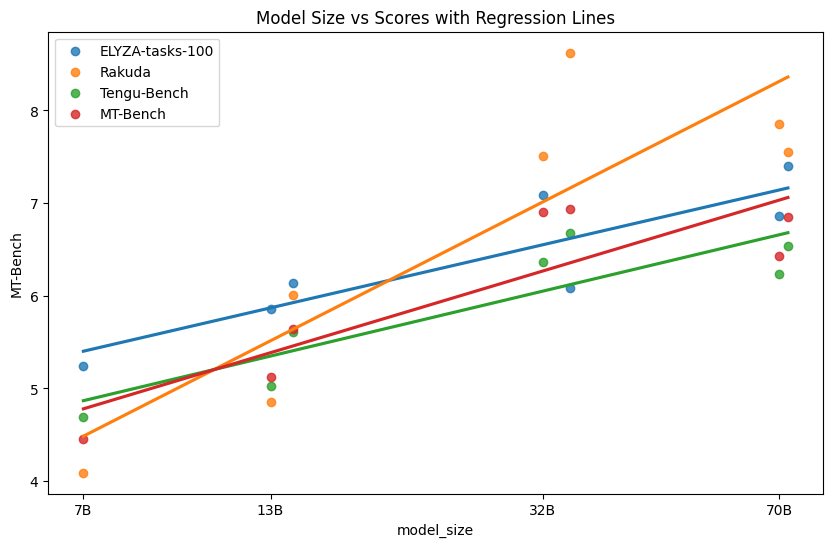

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns

# 図のサイズを設定
plt.figure(figsize=(10, 6))

# データごとに違う色で散布図と回帰直線を描画
colors = ['blue', 'green', 'red', 'gold']  # 色を指定
for i, column in enumerate(['ELYZA-tasks-100', 'Rakuda', 'Tengu-Bench', 'MT-Bench']):
    sns.regplot(x='model_size', y=column, data=log_size_df, scatter=True, 
                label=column, ci=None, )


plt.xticks([log(7), log(13), log(32), log(70)], ["7B", "13B", "32B", "70B"])
# 凡例を表示
plt.legend()
# タイトルを設定
plt.title('Model Size vs Scores with Regression Lines')
# グラフを表示
plt.savefig("model-size_vs_score.svg")
plt.show()

In [198]:
print(all_result_df[all_result_df['eval_dataset']=="Tengu-Bench"].groupby("Category").score.mean().sort_values(ascending=False).to_frame().to_latex())

\begin{tabular}{lr}
\toprule
 & score \\
Category &  \\
\midrule
アイデア生成 & 9.282828 \\
プロジェクト作成 & 9.230000 \\
長い文書要約（千トークン以上） & 9.130000 \\
会話要約 & 8.350000 \\
抽出 & 8.180000 \\
コスト見積 & 7.640000 \\
長い文書のClosed QA（千トークン以上） & 7.430000 \\
雑談 & 7.080000 \\
翻訳 & 6.820000 \\
敬語 & 6.660000 \\
Function calling & 6.140000 \\
フォーマット & 6.090000 \\
法律判断 & 5.040000 \\
架空の質問 & 4.920000 \\
建設 & 4.530000 \\
倫理的制御 & 4.120000 \\
ダジャレ & 3.770000 \\
表の読み取り & 3.390000 \\
ビジネス & 3.130000 \\
政治 & 2.950000 \\
日本 & 2.795000 \\
論理パズル & 2.190000 \\
数学 & 2.030000 \\
\bottomrule
\end{tabular}



In [4]:
all_result_df.groupby(
    ["model_name", "eval_dataset"]
).score.mean().reset_index(drop=False).pivot_table(values="score", index="model_name", columns="eval_dataset")

eval_dataset,elyza__ELYZA-tasks-100,lightblue__japanes-mt-bench-oneshot,lightblue__tengu_bench,yuzuai__rakuda-questions
model_name,,,,
Nexusflow__Starling-LM-7B-beta,2.87,5.612500,5.408333,4.425000
Qwen__Qwen1.5-14B-Chat,3.35,6.537500,6.200000,6.545000
Rakuten__RakutenAI-7B-chat,2.96,4.600000,5.241667,6.575000
augmxnt__shisa-7b-v1,1.86,2.225000,3.408333,2.225000
cyberagent__calm2-7b-chat,2.45,3.575000,4.808333,5.750000
elyza__ELYZA-japanese-Llama-2-13b-instruct,2.80,4.312500,5.516667,5.625000
gpt-3.5-turbo-0125,3.62,6.975000,6.816667,7.641026
gpt-4-turbo-preview,4.47,8.612500,7.841667,9.275000
lightblue__karasu_jlima,2.86,4.910256,5.133333,3.947368


In [199]:
mean_df = all_result_df.groupby(
    ["eval_dataset", "Category", "model_name"]
).score.mean().reset_index(level=1, drop=False).pivot_table(index='model_name', columns=['eval_dataset', 'Category'], values='score')

In [205]:
mean_df

eval_dataset                               MT-Bench                        \
Category                                     coding extraction humanities   
model_name                                                                  
CohereForAI__c4ai-command-r-v01                 6.9        6.6        8.4   
Nexusflow__Starling-LM-7B-beta                  5.3        6.3        6.1   
Qwen__Qwen1.5-14B-Chat                          5.4        7.4        7.0   
Qwen__Qwen1.5-32B-Chat                          5.7        7.4        7.6   
Qwen__Qwen1.5-72B-Chat                          6.7        6.9        7.7   
Qwen__Qwen1.5-7B-Chat                           4.9        6.3        5.2   
Rakuten__RakutenAI-7B-chat                      4.7        3.9        6.8   
augmxnt__shisa-7b-v1                            3.5        4.0        1.7   
cyberagent__calm2-7b-chat                       2.3        4.1        6.1   
elyza__ELYZA-japanese-Llama-2-13b-instruct      3.2        5.2        5.6   
gpt-3.5-turbo-0125                              7.0        8.8        7.3   
gpt-4-turbo-preview                             8.1        9.0        8.9   
karakuri-ai__karakuri-lm-70b-chat-v0.1          5.9        6.9        8.3   
lightblue__ao-karasu-72B                        6.0        7.3        7.5   
lightblue__qarasu-14B-chat-plus-unleashed       3.9        6.6        5.6   
meta-llama__Llama-2-13b-chat-hf                 3.6        6.0        8.7   
meta-llama__Llama-2-7b-chat-hf                  4.2        5.6        8.1   
mistralai__Mistral-7B-Instruct-v0.2             4.9        4.7        5.5   
openchat__openchat-3.5-0106                     5.4        5.9        5.2   
xverse__XVERSE-13B-Chat                         4.6        6.7        5.5   

eval_dataset                                                              \
Category                                   math reasoning  roleplay stem   
model_name                                                                 
CohereForAI__c4ai-command-r-v01             4.7  5.200000  7.666667  7.7   
Nexusflow__Starling-LM-7B-beta              5.5  5.100000  5.500000  4.1   
Qwen__Qwen1.5-14B-Chat                      5.4  5.300000  7.200000  7.0   
Qwen__Qwen1.5-32B-Chat                      6.2  6.000000  7.200000  7.2   
Qwen__Qwen1.5-72B-Chat                      6.8  4.800000  8.000000  7.9   
Qwen__Qwen1.5-7B-Chat                       4.7  4.300000  5.800000  5.0   
Rakuten__RakutenAI-7B-chat                  4.2  3.300000  4.600000  4.2   
augmxnt__shisa-7b-v1                        3.3  1.900000  1.100000  1.0   
cyberagent__calm2-7b-chat                   1.3  2.400000  4.300000  4.4   
elyza__ELYZA-japanese-Llama-2-13b-instruct  2.9  4.000000  4.700000  4.4   
gpt-3.5-turbo-0125                          6.8  4.200000  7.400000  7.0   
gpt-4-turbo-preview                         8.5  8.000000  8.700000  8.6   
karakuri-ai__karakuri-lm-70b-chat-v0.1      4.1  5.090909  6.800000  6.3   
lightblue__ao-karasu-72B                    5.0  5.600000  6.500000  6.6   
lightblue__qarasu-14B-chat-plus-unleashed   4.3  4.400000  3.100000  5.3   
meta-llama__Llama-2-13b-chat-hf             3.5  2.900000  5.900000  7.9   
meta-llama__Llama-2-7b-chat-hf              2.7  3.200000  6.100000  6.4   
mistralai__Mistral-7B-Instruct-v0.2         2.6  3.700000  5.200000  4.2   
openchat__openchat-3.5-0106                 4.4  4.700000  5.200000  4.6   
xverse__XVERSE-13B-Chat                     4.0  3.300000  6.100000  5.9   

eval_dataset                                            Tengu-Bench         \
Category                                   writing Function calling アイデア生成   
model_name                                                                   
CohereForAI__c4ai-command-r-v01                8.4              9.2   10.0   
Nexusflow__Starling-LM-7B-beta                 7.0              6.6    9.0   
Qwen__Qwen1.5-14B-Chat                         7.6              6.4   10.0   
Qwen__Qwen1

In [204]:
print(mean_df.to_markdown(index=True, floatfmt='.2f'))

| model_name                                 |   ('MT-Bench', 'coding') |   ('MT-Bench', 'extraction') |   ('MT-Bench', 'humanities') |   ('MT-Bench', 'math') |   ('MT-Bench', 'reasoning') |   ('MT-Bench', 'roleplay') |   ('MT-Bench', 'stem') |   ('MT-Bench', 'writing') |   ('Tengu-Bench', 'Function calling') |   ('Tengu-Bench', 'アイデア生成') |   ('Tengu-Bench', 'コスト見積') |   ('Tengu-Bench', 'ダジャレ') |   ('Tengu-Bench', 'ビジネス') |   ('Tengu-Bench', 'フォーマット') |   ('Tengu-Bench', 'プロジェクト作成') |   ('Tengu-Bench', '会話要約') |   ('Tengu-Bench', '倫理的制御') |   ('Tengu-Bench', '建設') |   ('Tengu-Bench', '抽出') |   ('Tengu-Bench', '政治') |   ('Tengu-Bench', '敬語') |   ('Tengu-Bench', '数学') |   ('Tengu-Bench', '日本') |   ('Tengu-Bench', '架空の質問') |   ('Tengu-Bench', '法律判断') |   ('Tengu-Bench', '翻訳') |   ('Tengu-Bench', '表の読み取り') |   ('Tengu-Bench', '論理パズル') |   ('Tengu-Bench', '長い文書のClosed QA（千トークン以上）') |   ('Tengu-Bench', '長い文書要約（千トークン以上）') |   ('Tengu-Bench', '雑談') |
|:-----------------------------------------

In [200]:
mean_df

eval_dataset                               MT-Bench                        \
Category                                     coding extraction humanities   
model_name                                                                  
CohereForAI__c4ai-command-r-v01                 6.9        6.6        8.4   
Nexusflow__Starling-LM-7B-beta                  5.3        6.3        6.1   
Qwen__Qwen1.5-14B-Chat                          5.4        7.4        7.0   
Qwen__Qwen1.5-32B-Chat                          5.7        7.4        7.6   
Qwen__Qwen1.5-72B-Chat                          6.7        6.9        7.7   
Qwen__Qwen1.5-7B-Chat                           4.9        6.3        5.2   
Rakuten__RakutenAI-7B-chat                      4.7        3.9        6.8   
augmxnt__shisa-7b-v1                            3.5        4.0        1.7   
cyberagent__calm2-7b-chat                       2.3        4.1        6.1   
elyza__ELYZA-japanese-Llama-2-13b-instruct      3.2        5.2        5.6   
gpt-3.5-turbo-0125                              7.0        8.8        7.3   
gpt-4-turbo-preview                             8.1        9.0        8.9   
karakuri-ai__karakuri-lm-70b-chat-v0.1          5.9        6.9        8.3   
lightblue__ao-karasu-72B                        6.0        7.3        7.5   
lightblue__qarasu-14B-chat-plus-unleashed       3.9        6.6        5.6   
meta-llama__Llama-2-13b-chat-hf                 3.6        6.0        8.7   
meta-llama__Llama-2-7b-chat-hf                  4.2        5.6        8.1   
mistralai__Mistral-7B-Instruct-v0.2             4.9        4.7        5.5   
openchat__openchat-3.5-0106                     5.4        5.9        5.2   
xverse__XVERSE-13B-Chat                         4.6        6.7        5.5   

eval_dataset                                                              \
Category                                   math reasoning  roleplay stem   
model_name                                                                 
CohereForAI__c4ai-command-r-v01             4.7  5.200000  7.666667  7.7   
Nexusflow__Starling-LM-7B-beta              5.5  5.100000  5.500000  4.1   
Qwen__Qwen1.5-14B-Chat                      5.4  5.300000  7.200000  7.0   
Qwen__Qwen1.5-32B-Chat                      6.2  6.000000  7.200000  7.2   
Qwen__Qwen1.5-72B-Chat                      6.8  4.800000  8.000000  7.9   
Qwen__Qwen1.5-7B-Chat                       4.7  4.300000  5.800000  5.0   
Rakuten__RakutenAI-7B-chat                  4.2  3.300000  4.600000  4.2   
augmxnt__shisa-7b-v1                        3.3  1.900000  1.100000  1.0   
cyberagent__calm2-7b-chat                   1.3  2.400000  4.300000  4.4   
elyza__ELYZA-japanese-Llama-2-13b-instruct  2.9  4.000000  4.700000  4.4   
gpt-3.5-turbo-0125                          6.8  4.200000  7.400000  7.0   
gpt-4-turbo-preview                         8.5  8.000000  8.700000  8.6   
karakuri-ai__karakuri-lm-70b-chat-v0.1      4.1  5.090909  6.800000  6.3   
lightblue__ao-karasu-72B                    5.0  5.600000  6.500000  6.6   
lightblue__qarasu-14B-chat-plus-unleashed   4.3  4.400000  3.100000  5.3   
meta-llama__Llama-2-13b-chat-hf             3.5  2.900000  5.900000  7.9   
meta-llama__Llama-2-7b-chat-hf              2.7  3.200000  6.100000  6.4   
mistralai__Mistral-7B-Instruct-v0.2         2.6  3.700000  5.200000  4.2   
openchat__openchat-3.5-0106                 4.4  4.700000  5.200000  4.6   
xverse__XVERSE-13B-Chat                     4.0  3.300000  6.100000  5.9   

eval_dataset                                            Tengu-Bench         \
Category                                   writing Function calling アイデア生成   
model_name                                                                   
CohereForAI__c4ai-command-r-v01                8.4              9.2   10.0   
Nexusflow__Starling-LM-7B-beta                 7.0              6.6    9.0   
Qwen__Qwen1.5-14B-Chat                         7.6              6.4   10.0   
Qwen__Qwen1

In [213]:
mean_df = all_result_df.groupby(
    ["model_name", "eval_dataset"]
).score.mean().reset_index(level=1, drop=False)

In [217]:
mean_df['score_'] = mean_df.apply(lambda x: x.score*2 if x.eval_dataset=="ELYZA-tasks-100" else x.score, axis=1)

In [214]:
unique_models = mean_df.index.unique()

In [219]:
import plotly.graph_objects as go
from plotly import offline

fig = go.Figure()

for unique_model in unique_models:
    
    model_mean_df = mean_df.loc[unique_model]
    
    fig.add_trace(go.Scatterpolar(
          r=model_mean_df["score_"],
          theta=model_mean_df["eval_dataset"],
          fill='toself',
          name=unique_model
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 10]
    )),
  showlegend=True
)

# fig.show()
offline.plot(fig)


'temp-plot.html'